# Import Packages and libraries

In [9]:
%%capture
!pip install numpy==1.17.4
!pip install nltk==3.4.5
!pip install torchtext==0.4.0
!pip install scikit_learn==0.23.2
!pip install spacy==2.3.5
!pip install textblob==0.15.3
!pip install torch==1.6.0 
!pip install torchvision==0.7.0
!pip install tqdm
!pip install underthesea==1.3.3
!pip install rouge_score

In [10]:
import nltk
nltk.download('wordnet')

import os
import math
import random
import argparse
from pathlib import Path
import re
import numpy as np
import pandas as pd
import time
import gc
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, Example, Dataset
from torchtext.data import BucketIterator
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

%rm -rf ./UIT-ViCoV19QA
!git clone https://github.com/minhtriet2397/UIT-ViCoV19QA.git

sys.path.insert(0, '..')
sys.path.insert(0, '/kaggle/working/UIT-ViCoV19QA/models')
%cd /kaggle/working/UIT-ViCoV19QA/models
%pwd

sys.argv=['']
del sys

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cloning into 'UIT-ViCoV19QA'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 62 (delta 20), reused 51 (delta 15), pack-reused 0
Unpacking objects: 100% (62/62), 1.72 MiB | 1.50 MiB/s, done.
/kaggle/working/UIT-ViCoV19QA/models


# Main

In [11]:
"""Constants for the baseline models"""
SEED = 42
QUESTION = 'question'

RNN_NAME = 'rnn'
CNN_NAME = 'cnn'
TRANSFORMER_NAME = 'transformer'

ATTENTION_1 = 'bahdanau'
ATTENTION_2 = 'luong'

GPU = 'gpu'
CPU = 'cpu'
CUDA = 'cuda'

CHECKPOINT_PATH = '/model/'

ANSWER_TOKEN = '<ans>'
ENTITY_TOKEN = '<ent>'
EOS_TOKEN = '<eos>'
SOS_TOKEN = '<sos>'
PAD_TOKEN = '<pad>'

SRC_NAME = 'src'
TRG_NAME = 'trg'

path = '/kaggle/working/'

In [12]:
import random
import numpy as np

def parse_args():
    """Add arguments to parser"""
    parser = argparse.ArgumentParser(description='Verbalization dataset baseline models.')
    parser.add_argument('--model', default=RNN_NAME, type=str,
                        choices=[RNN_NAME, CNN_NAME, TRANSFORMER_NAME], help='model to train the dataset')
    parser.add_argument('--input', default=QUESTION, type=str,
                        choices=[QUESTION], help='use question as input')
    parser.add_argument('--attention', default=ATTENTION_2, type=str,
                        choices=[ATTENTION_1, ATTENTION_2], help='attention layer for rnn model')
    parser.add_argument('--batch_size', default=8, type=int, help='batch size')
    parser.add_argument('--epochs_num', default=30, type=int, help='number of epochs')
    parser.add_argument('--answer_num', default=1, type=int, 
                        choices=[1,2,3,4], help='number of answer')
    args = parser.parse_args()
    return args

def set_SEED():
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

class Checkpoint(object):
    """Checkpoint class"""
    @staticmethod
    def save(model,cell, path):
        """Save model using name"""
        name_tmp = model.name+"_"+ cell if model.name==RNN_NAME else model.name
        name = f'{name_tmp}.pt'
        torch.save(model.state_dict(), path+name)

    @staticmethod
    def load(model,path, name):
        """Load model using name"""
        #name = f'{model.name}.pt'
        model.load_state_dict(torch.load(path+name))
        return model

## Import data and create torchtext dataset

In [13]:
from underthesea import word_tokenize

class VerbalDataset(object):
    """VerbalDataset class"""
                                         
    def __init__(self,train,val,test):
        self.train = train
        self.val = val
        self.test = test
        self.train_data = None
        self.valid_data = None
        self.test_data = None
        self.src_field = None
        self.trg_field = None

    def _make_torchtext_dataset(self, data, fields):
        examples = [Example.fromlist(i, fields) for i in tqdm_notebook(data)]
        return Dataset(examples, fields)

    def load_data_and_fields(self, ):
        """
        Load verbalization data
        Create source and target fields
        """
        train, test, val = self.train, self.test, self.val
        
        train = train.melt(id_vars=['id',"Question"],value_name="Answer")
        train = train[train['Answer'].astype(bool)].drop(['id','variable'],axis=1).values
        
        test = test.melt(id_vars=['id',"Question"],value_name="Answer")
        test = test[test['Answer'].astype(bool)].drop(['id','variable'],axis=1).values
        
        val = val.melt(id_vars=['id',"Question"],value_name="Answer")
        val = val[val['Answer'].astype(bool)].drop(['id','variable'],axis=1).values

        # create fields
        self.src_field = Field(tokenize=word_tokenize,
                               init_token=SOS_TOKEN,
                               eos_token=EOS_TOKEN,
                               lower=True,
                               include_lengths=True,
                               batch_first=True)
        
        self.trg_field = Field(tokenize=word_tokenize,
                               init_token=SOS_TOKEN,
                               eos_token=EOS_TOKEN,
                               lower=True,
                               batch_first=True)

        fields_tuple = [(SRC_NAME, self.src_field), (TRG_NAME, self.trg_field)]

        # create toechtext datasets
        self.train_data = self._make_torchtext_dataset(train, fields_tuple)
        self.valid_data = self._make_torchtext_dataset(val, fields_tuple)
        self.test_data = self._make_torchtext_dataset(test, fields_tuple)

        # build vocabularies
        self.src_field.build_vocab(self.train_data, min_freq=1)
        self.trg_field.build_vocab(self.train_data, min_freq=1)
        print("i am field tuple",fields_tuple)

    def get_data(self):
        """Return train, validation and test data objects"""
        return self.train_data, self.valid_data, self.test_data

    def get_fields(self):
        """Return source and target field objects"""
        return self.src_field, self.trg_field

    def get_vocabs(self):
        """Return source and target vocabularies"""
        #print('self, trg field vocab: ', self.trg_field.vocab)
        return self.src_field.vocab, self.trg_field.vocab

In [14]:
set_SEED()
args = parse_args()
answer_num = args.answer_num

set_ = ['train','val','test']
train = pd.read_csv(f'{path}UIT-ViCoV19QA/dataset/{answer_num}_ans/UIT-ViCoV19QA_train.csv',na_filter=False,delimiter='|')
val = pd.read_csv(f'{path}UIT-ViCoV19QA/dataset/{answer_num}_ans/UIT-ViCoV19QA_val.csv',na_filter=False,delimiter='|')
test = pd.read_csv(f'{path}UIT-ViCoV19QA/dataset/{answer_num}_ans/UIT-ViCoV19QA_test.csv',na_filter=False,delimiter='|')

dataset = VerbalDataset(train,val,test)
dataset.load_data_and_fields()
src_vocab, trg_vocab = dataset.get_vocabs()
train_data, valid_data, test_data = dataset.get_data()

print('--------------------------------')
print(f"Training data: {len(train_data.examples)}")
print(f"Evaluation data: {len(valid_data.examples)}")
print(f"Testing data: {len(test_data.examples)}")
print('--------------------------------')
print(f'Question example: {train_data.examples[2].src}\n')
print(f'Answer example: {train_data.examples[2].trg}')
print('--------------------------------')
print(f"Unique tokens in questions vocabulary: {len(src_vocab)}")
print(f"Unique tokens in answers vocabulary: {len(trg_vocab)}")
print('--------------------------------')

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

i am field tuple [('src', <torchtext.data.field.Field object at 0x7f928e083990>), ('trg', <torchtext.data.field.Field object at 0x7f928e083050>)]
--------------------------------
Training data: 3500
Evaluation data: 500
Testing data: 500
--------------------------------
Question example: ['tôi', 'đang', 'cho', 'con', 'bú', '(', '10', 'tháng', 'tuổi', ')', 'có', 'được', 'chủng', 'ngừa', 'vaccine', 'covid-19', 'không', '?', 'trẻ nhỏ', 'bao nhiêu', 'tháng', 'tuổi', 'mới', 'chủng', 'ngừa', 'được', 'vaccine', 'covid-19', 'ạ', '?', 'xin', 'cảm ơn', '!']

Answer example: ['chào', 'chị', ',', 'theo', 'hướng dẫn', 'của', 'bộ', 'y tế', ',', 'phụ nữ', 'đang', 'cho', 'con', 'bú', 'sẽ', 'hoãn', 'tiêm', 'vaccine', 'covid-19', 'trong', 'thời gian', 'này', '.', 'hiện nay', ',', 'mỗi', 'loại', 'vaccine', 'sẽ', 'chỉ định', 'ở', 'những', 'đối tượng', 'khác', 'nhau', 'như', 'vaccine covid-19', 'của', 'astrazeneca', 'chỉ định', 'tiêm chủng', 'cho', 'người', 'từ', '18', 'tuổi', 'trở lên', ',', 'vaccine', 'c

## Define MODEL

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, name):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.name = name

    def forward(self, src_tokens, src_lengths, trg_tokens, teacher_forcing_ratio=0.5):
        encoder_out = self.encoder(src_tokens, 
                                   src_lengths=src_lengths)
       
        decoder_out = self.decoder(trg_tokens, encoder_out,
                                   src_tokens=src_tokens,
                                   teacher_forcing_ratio=teacher_forcing_ratio)
        return decoder_out

In [16]:
# Choose model here
args.model = CNN_NAME # CNN and Transformers don't apply Attention_1, Attention_2
args.attention = ATTENTION_1
cell_name = 'gru'

if args.model == RNN_NAME and args.attention == ATTENTION_1:
    from rnn1 import Encoder, Decoder
elif args.model == RNN_NAME and args.attention == ATTENTION_2:
    from rnn2 import Encoder, Decoder
elif args.model == CNN_NAME:
    from cnn import Encoder, Decoder
elif args.model == TRANSFORMER_NAME:
    from transformer import Encoder, Decoder, NoamOpt

In [17]:
set_SEED()
DEVICE = torch.device(CUDA if torch.cuda.is_available() else CPU)

if args.model == RNN_NAME and args.attention == ATTENTION_2:
    encoder = Encoder(src_vocab, DEVICE, cell_name)
    decoder = Decoder(trg_vocab, DEVICE, cell_name)
else:
    encoder = Encoder(src_vocab, DEVICE)
    decoder = Decoder(trg_vocab, DEVICE)
model = Seq2Seq(encoder, decoder, args.model).to(DEVICE)

parameters_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('--------------------------------')
print(f'Model: {args.model}')
print(f'Model input: {args.input}')
if args.model == RNN_NAME:
    print(f'Attention: {args.attention}')
    print('Cell name: ',cell_name)
print(f'The model has {parameters_num:,} trainable parameters')
print('--------------------------------')

--------------------------------
Model: cnn
Model input: question
The model has 28,191,065 trainable parameters
--------------------------------


## Train model

In [18]:
class Evaluator(object):
    """Evaluator class"""
    def __init__(self, criterion):
        self.criterion = criterion

    def evaluate(self, model, iterator, teacher_ratio=1.0):
        model.eval()
        epoch_loss = 0
        with torch.no_grad():
            for _, batch in enumerate(iterator):
                src, src_len = batch.src
                trg = batch.trg
                input_trg = trg if model.name == RNN_NAME else trg[:, :-1]
                output = model(src, src_len, input_trg, teacher_ratio)
                trg = trg.t() if model.name == RNN_NAME else trg[:, 1:]
                output = output.contiguous().view(-1, output.shape[-1])
                trg = trg.contiguous().view(-1)
                # output: (batch_size * trg_len) x output_dim
                # trg: (batch_size * trg_len)
                loss = self.criterion(output, trg)
                epoch_loss += loss.item()
        return epoch_loss / len(iterator)

In [19]:
from torch.cuda.amp import autocast, GradScaler

class Trainer(object):
    """Trainer Class"""
    def __init__(self, optimizer, criterion, batch_size, device):
        self.optimizer = optimizer
        self.criterion = criterion
        self.batch_size = batch_size
        self.device = device
        self.evaluator = Evaluator(criterion=self.criterion)

    def _train_batch(self, model, iterator, teacher_ratio, clip):
        model.train()
        epoch_loss = 0
        #scaler = GradScaler()
        for _, batch in enumerate(tqdm_notebook(iterator)):
            src, src_len = batch.src
            trg = batch.trg
            self.optimizer.zero_grad()
            input_trg = trg if model.name == RNN_NAME else trg[:, :-1]
            output = model(src, src_len, input_trg, teacher_ratio)
            trg = trg.t() if model.name == RNN_NAME else trg[:, 1:]
            output = output.contiguous().view(-1, output.shape[-1])
            trg = trg.contiguous().view(-1)
            # output: (batch_size * trg_len) x output_dim
            # trg: (batch_size * trg_len)
            torch.cuda.empty_cache()
            loss = self.criterion(output, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            self.optimizer.step()
            epoch_loss += loss.item()
                
        return epoch_loss / len(iterator)

    def _get_iterators(self, train_data, valid_data, model_name):
        return BucketIterator.splits((train_data, valid_data),
                                     batch_size=self.batch_size,
                                     sort_within_batch=True if model_name == RNN_NAME else \
                                                       False,
                                     sort_key=lambda x: len(x.src),
                                     device=self.device)

    def _epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def _log_epoch(self, train_loss, valid_loss, epoch, start_time, end_time):
        minutes, seconds = self._epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {minutes}m {seconds}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

    def _train_epoches(self, model, train_data, valid_data,  path_, num_of_epochs, teacher_ratio, clip):
        best_valid_loss = float('inf')
        # pylint: disable=unbalanced-tuple-unpacking
        train_iterator, valid_iterator = self._get_iterators(train_data, valid_data, model.name)
        train_loss_list = []
        val_loss_list = []
        for epoch in range(num_of_epochs):
            start_time = time.time()
            train_loss = self._train_batch(model, train_iterator, teacher_ratio, clip)
            valid_loss = self.evaluator.evaluate(model, valid_iterator, teacher_ratio)
            
            train_loss_list.append(train_loss)
            val_loss_list.append(valid_loss)
            
            end_time = time.time()
            self._log_epoch(train_loss, valid_loss, epoch, start_time, end_time)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                Checkpoint.save(model,cell_name,path_)
        return train_loss_list, val_loss_list

    def train(self, model, train_data, valid_data, path_, num_of_epochs=20, teacher_ratio=1.0, clip=1):
        """Train model"""
        return self._train_epoches(model, train_data, valid_data, path_, num_of_epochs, teacher_ratio, clip)

In [20]:
# create optimizer
if args.model ==TRANSFORMER_NAME:
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    optimizer = NoamOpt(torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
else:
    optimizer = optim.Adam(model.parameters(),lr=0.001)

batch_size = 8
epochs=10

# define criterion
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab.stoi[PAD_TOKEN])

trainer = Trainer(optimizer, criterion, batch_size, DEVICE)
train_loss, val_loss = trainer.train(model, train_data, valid_data, path, num_of_epochs=epochs)

  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 28s
	Train Loss: 5.281 | Train PPL: 196.623
	 Val. Loss: 4.216 |  Val. PPL:  67.775


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 02 | Time: 0m 27s
	Train Loss: 4.260 | Train PPL:  70.826
	 Val. Loss: 3.829 |  Val. PPL:  46.032


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 03 | Time: 0m 28s
	Train Loss: 3.869 | Train PPL:  47.907
	 Val. Loss: 3.614 |  Val. PPL:  37.105


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 04 | Time: 0m 28s
	Train Loss: 3.628 | Train PPL:  37.635
	 Val. Loss: 3.497 |  Val. PPL:  33.008


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 05 | Time: 0m 28s
	Train Loss: 3.461 | Train PPL:  31.849
	 Val. Loss: 3.420 |  Val. PPL:  30.578


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 06 | Time: 0m 28s
	Train Loss: 3.305 | Train PPL:  27.254
	 Val. Loss: 3.359 |  Val. PPL:  28.772


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 07 | Time: 0m 28s
	Train Loss: 3.204 | Train PPL:  24.640
	 Val. Loss: 3.330 |  Val. PPL:  27.945


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 08 | Time: 0m 28s
	Train Loss: 3.103 | Train PPL:  22.255
	 Val. Loss: 3.307 |  Val. PPL:  27.293


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 09 | Time: 0m 28s
	Train Loss: 3.017 | Train PPL:  20.422
	 Val. Loss: 3.298 |  Val. PPL:  27.063


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch: 10 | Time: 0m 28s
	Train Loss: 2.958 | Train PPL:  19.267
	 Val. Loss: 3.283 |  Val. PPL:  26.656


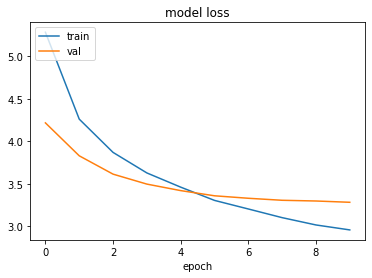

In [21]:
import matplotlib.pyplot as plt
import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

#plt.savefig('loss.png')
plt.show()

## Evaluation

In [28]:
val_ref = [list(filter(None, np.delete(i,[0,1]))) for i in val.values]
test_ref = [list(filter(None, np.delete(i,[0,1]))) for i in test.values]

val_trg = []
test_trg = []
trg_ = [val_trg,test_trg]
for t in trg_:
    for i in val_ref:
        tmp=[]
        for j in i:
            s = word_tokenize(j)
            tmp.append(s)
        t.append(tmp)

val_src = [i.src for i in valid_data.examples]
new_valid = [[val_src[i],val_trg[i]] for i in range(len(val_trg)) ]
test_src = [i.src for i in test_data.examples]
new_test = [[test_src[i],test_trg[i]] for i in range(len(test_trg))]

In [24]:
import nltk
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer

smoothie = SmoothingFunction().method4

class BleuScorer(object):
    """Blue scorer class"""
    def __init__(self):
        self.results = []
        self.results_meteor = []
        
        self.score = 0
        self.bleu_4 = 0
        self.meteor_score = 0
        self.rouge_score = 0
        
        self.instances = 0
        self.meteor_instances = 0

    def example_score(self, reference, hypothesis):
        """Calculate blue score for one example"""
        bleu_1 = nltk.translate.bleu_score.sentence_bleu(reference, hypothesis,weights=(1,0,0,0),smoothing_function=SmoothingFunction().method4)
        bleu_4 = nltk.translate.bleu_score.sentence_bleu(reference, hypothesis,weights=(0.25,0.25,0.25,0.25),smoothing_function=SmoothingFunction().method4)
        return bleu_1, bleu_4
    
    def example_score_rouge(self, reference, hypothesis):
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
        scores = []
        for i in reference:
            scores.append(scorer.score(i,hypothesis)['rougeL'][-1])
        return np.max(scores) #best
    
    
    def example_score_meteor(self, reference, hypothesis):
        """Calculate blue score for one example"""
        return nltk.translate.meteor_score.meteor_score(reference,hypothesis)

    def data_score(self, data, predictor):
        """Score complete list of data"""
        results_prelim = []
        for example in tqdm_notebook(data):
            #i = 1
#             src = [t.lower() for t in example.src]
#             reference = [t.lower() for t in example.trg]
            
            src = example[0]
            reference = [[string.lower() for string in sublist] for sublist in example[1]]

            #and calculate bleu score average of all hypothesis
            #hypothesis = predictor.predict(example.src)
            hypothesis = predictor.predict(src)
            bleu_1,bleu_4 = self.example_score(reference, hypothesis)
            meteor_score = self.example_score_meteor([' '.join(i) for i in reference], ' '.join(hypothesis))
            rouge_score = self.example_score_rouge([' '.join(i) for i in reference], ' '.join(hypothesis))
            
            f = open("result.txt", "a")
            f.write('Question: '+" ".join(src)+'\n')
            for i in range(len(reference)):
                f.write('Reference_{}: '.format(i)+" ".join(reference[i])+'\n')
            f.write('Hypothesis: '+" ".join(hypothesis)+'\n')
            f.write('BLEU-1: '+ str(bleu_1*100)+'\n')
            f.write('BLEU-4: '+str(bleu_4*100)+'\n')
            f.write('METEOR: '+str(meteor_score*100)+'\n')
            f.write('ROUGE-L: '+str(rouge_score*100)+'\n\n')
            
            f.close()
            
            
            results_prelim.append({
                'question': '"' + str(src) + '"',
                'reference': reference,
                'hypothesis': hypothesis,
                'bleu_1': bleu_1,
                'bleu_4': bleu_4,
                'meteor_score': meteor_score,
                'rouge_score': rouge_score,
                
            })
            
        results = [max((v for v in results_prelim if v['question'] == x), key=lambda y:y['bleu_1']) for x in set(v['question'] for v in results_prelim)] 

        with open(path+'result_output.txt', 'w') as f:
            for elem in results:
                f.write("%s\n" % elem)
                self.results.append(elem)
                self.score += elem['bleu_1']
                self.bleu_4 += elem['bleu_4']
                self.meteor_score += elem['meteor_score']
                self.rouge_score += elem['rouge_score']
                self.instances += 1
        return self.score / self.instances, self.bleu_4 / self.instances, self.meteor_score / self.instances, self.rouge_score / self.instances

    def average_score(self):
        """Return bleu average score"""
        return self.score / self.instances, self.bleu_4 / self.instances
    
    def average_rouge_score(self):
        """Return bleu average score"""
        return self.rouge_score / self.instances
    
    
    def data_meteor_score(self, data, predictor):
        """Score complete list of data"""
        results_prelim = []
        for example in data:
            src = [t.lower() for t in example.src]
            reference = [t.lower() for t in example.trg]
            hypothesis = predictor.predict(example.src)
            meteor_score = self.example_score_meteor(' '.join(reference), ' '.join(hypothesis))
            results_prelim.append({
                'question': '"' + str(src) + '"',
                'reference': reference,
                'hypothesis': hypothesis,
                'meteor_score': meteor_score
            })
        results_meteor = [max((v for v in results_prelim if v['question'] == x), key=lambda y:y['meteor_score']) for x in set(v['question'] for v in results_prelim)] 

        with open(path+'result_meteor_output.txt', 'w') as f:
            for elem in results_meteor:
                f.write("%s\n" % elem)
                self.results_meteor.append(elem)
                self.meteor_score += elem['meteor_score']
                self.meteor_instances += 1
        return self.meteor_score/self.meteor_instances
    
    def average_meteor_score(self):
        """Return meteor average score"""
        return self.meteor_score/self.instances

    def reset(self):
        """Reset object properties"""
        self.results = []
        self.results_meteor = []
        self.score = 0
        self.meteor_score = 0
        self.instances = 0
        self.meteor_instances = 0

In [25]:
class Predictor(object):
    """Predictor class"""
    def __init__(self, model, src_vocab, trg_vocab, device):
        self.model = model
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.device = device

    def _predict_step(self, tokens):
        self.model.eval()
        tokenized_sentence = [SOS_TOKEN] + [t.lower() for t in tokens] + [EOS_TOKEN]
        numericalized = [self.src_vocab.stoi[token] for token in tokenized_sentence]
        src_tensor = torch.LongTensor(numericalized).unsqueeze(0).to(self.device)

        with torch.no_grad():
            encoder_out = self.model.encoder(src_tensor)

        outputs = [self.trg_vocab.stoi[SOS_TOKEN]]

        # cnn positional embedding gives assertion error for tensor
        # of size > max_positions-1, we predict tokens for max_positions-2
        # to avoid the error
        for _ in range(self.model.decoder.max_positions-2):
            trg_tensor = torch.LongTensor(outputs).unsqueeze(0).to(self.device)

            with torch.no_grad():
                output = self.model.decoder(trg_tensor, encoder_out, src_tokens=src_tensor)

            prediction = output.argmax(2)[:, -1].item()

            if prediction == self.trg_vocab.stoi[EOS_TOKEN] or len(outputs)==500:
                break
                
            outputs.append(prediction)

        translation = [self.trg_vocab.itos[i] for i in outputs]

        return translation[1:] # , attention

    def _predict_rnn_step(self, tokens):
        self.model.eval()
        with torch.no_grad():
            tokenized_sentence = [SOS_TOKEN] + [t.lower() for t in tokens] + [EOS_TOKEN]
            numericalized = [self.src_vocab.stoi[t] for t in tokenized_sentence]

            src_len = torch.LongTensor([len(numericalized)]).to(self.device)
            tensor = torch.LongTensor(numericalized).unsqueeze(1).to(self.device)

            translation_tensor_logits = self.model(tensor.t(), src_len, None)

            translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
            translation = [self.trg_vocab.itos[t] for t in translation_tensor]

        return translation[1:] # , attention

    def predict(self, tokens):
        """Perform prediction on given tokens"""
        return self._predict_rnn_step(tokens) if self.model.name == RNN_NAME else \
                self._predict_step(tokens)

In [26]:
name = args.model+"_"+cell_name if args.model==RNN_NAME else args.model
model = Checkpoint.load(model,path,'./{}.pt'.format(name))

valid_iterator, test_iterator = BucketIterator.splits(
                                    (valid_data, test_data),
                                    batch_size=8,
                                    sort_within_batch=True if args.model == RNN_NAME else False,
                                    sort_key=lambda x: len(x.src),
                                    device=DEVICE)

# evaluate model
valid_loss = trainer.evaluator.evaluate(model, valid_iterator)
test_loss = trainer.evaluator.evaluate(model, test_iterator)

# calculate blue score for valid and test data
predictor = Predictor(model, src_vocab, trg_vocab, DEVICE)

# # train_scorer = BleuScorer()
valid_scorer = BleuScorer()
test_scorer = BleuScorer()

valid_scorer.data_score(new_valid, predictor)
test_scorer.data_score(new_test, predictor)

  0%|          | 0/500 [00:00<?, ?it/s]

| Test Loss: 3.169 | Test PPL:  23.787 |
| Test Data Average BLEU score (0.13299530736768786, 0.08383683068952133) |
| Test Data Average METEOR score 0.14519957374057366 |


In [ ]:
print(f'| Val. Loss: {valid_loss:.3f} | Test PPL: {math.exp(valid_loss):7.3f} |')
print(f'| Val. Data Average BLEU1, BLEU4 score {valid_scorer.average_score()} |')
print(f'| Val. Data Average METEOR score {valid_scorer.average_meteor_score()} |')
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')
print(f'| Test Data Average BLEU1, BLEU4 score {test_scorer.average_score()} |')
print(f'| Test Data Average METEOR score {test_scorer.average_meteor_score()} |')

In [27]:
r = {'ppl':[round(math.exp(test_loss),3)],
     'BLEU-1':[test_scorer.average_score()[0]*100],
     'BLEU-4':[test_scorer.average_score()[1]*100],
     'METEOR':[test_scorer.average_meteor_score()*100],
     'ROUGE-L':[test_scorer.average_rouge_score()*100]}

df_result = pd.DataFrame(data=r)

html = df_result.style.set_table_styles([{'selector': 'th', 'props': [('font-size', '15pt')]}]).set_properties(**{'font-size': '15pt'})
html

,ppl,BLEU-1,BLEU-4,METEOR,ROUGE-L
0,23.787000,13.299531,8.383683,14.519957,27.549394
